In [16]:
!pip install transformers datasets torch accelerate bitsandbytes trl peft evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00


## Import Required Libraries

In [2]:
import torch
import os
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device} and device name {torch.cuda.get_device_name()}")

from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer

from getpass import getpass

os.environ["HF_TOKEN"] = getpass("Enter API Key : ")

In [3]:
from IPython.display import display, Markdown
from transformers import AutoModelForImageTextToText, AutoProcessor, BitsAndBytesConfig
from peft import LoraConfig

In [4]:
import torch

def gpu(label=""):
    allocated = torch.cuda.memory_allocated() / 1024**3
    reserved = torch.cuda.memory_reserved() / 1024**3
    print(f"{label}: Allocated={allocated:.2f}GB Reserved={reserved:.2f}GB")

In [5]:
gpu("Before model data loading")

Before model data loading: Allocated=0.00GB Reserved=0.00GB


## Prepare fine-tuning dataset

We will be using the "NCT-CRC-HE-100K" dataset, containing image patches from historical images of human colorectal cancer (CRC) and normal tissue, to fine-tune MedGemma to classify tissue types.

We will be using 10K images for fine-tuning to keep the training samples small and fast to train.

We will download the dataset from external sources

In [5]:
dataset = load_dataset("1aurent/NCT-CRC-HE", split = "CRC_VAL_HE_7K")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

data/CRC_VAL_HE_7K-00000-of-00003-cce109(…):   0%|          | 0.00/311M [00:00<?, ?B/s]

data/CRC_VAL_HE_7K-00001-of-00003-fbb5de(…):   0%|          | 0.00/353M [00:00<?, ?B/s]

data/CRC_VAL_HE_7K-00002-of-00003-2009e8(…):   0%|          | 0.00/278M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00000-of-00031-9780(…):   0%|          | 0.00/488M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00001-of-00031-89eb(…):   0%|          | 0.00/488M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00002-of-00031-0ee8(…):   0%|          | 0.00/487M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00003-of-00031-264d(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00004-of-00031-0419(…):   0%|          | 0.00/491M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00005-of-00031-6929(…):   0%|          | 0.00/491M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00006-of-00031-139c(…):   0%|          | 0.00/454M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00007-of-00031-7240(…):   0%|          | 0.00/299M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00008-of-00031-164c(…):   0%|          | 0.00/299M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00009-of-00031-a88c(…):   0%|          | 0.00/298M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00010-of-00031-10d1(…):   0%|          | 0.00/484M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00011-of-00031-9586(…):   0%|          | 0.00/491M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00012-of-00031-6808(…):   0%|          | 0.00/491M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00013-of-00031-78a6(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00014-of-00031-a591(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00015-of-00031-72d5(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00016-of-00031-08c5(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00017-of-00031-240f(…):   0%|          | 0.00/488M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00018-of-00031-84ed(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00019-of-00031-e4a4(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00020-of-00031-5320(…):   0%|          | 0.00/413M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00021-of-00031-e828(…):   0%|          | 0.00/150M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00022-of-00031-1795(…):   0%|          | 0.00/152M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00023-of-00031-0c17(…):   0%|          | 0.00/151M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00024-of-00031-6724(…):   0%|          | 0.00/473M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00025-of-00031-06d3(…):   0%|          | 0.00/488M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00026-of-00031-2cd8(…):   0%|          | 0.00/488M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00027-of-00031-76ba(…):   0%|          | 0.00/484M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00028-of-00031-6161(…):   0%|          | 0.00/484M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00029-of-00031-01d8(…):   0%|          | 0.00/484M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K-00030-of-00031-3df3(…):   0%|          | 0.00/484M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00000-of-000(…):   0%|          | 0.00/488M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00001-of-000(…):   0%|          | 0.00/488M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00002-of-000(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00003-of-000(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00004-of-000(…):   0%|          | 0.00/491M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00005-of-000(…):   0%|          | 0.00/491M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00006-of-000(…):   0%|          | 0.00/452M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00007-of-000(…):   0%|          | 0.00/289M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00008-of-000(…):   0%|          | 0.00/289M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00009-of-000(…):   0%|          | 0.00/290M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00010-of-000(…):   0%|          | 0.00/484M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00011-of-000(…):   0%|          | 0.00/491M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00012-of-000(…):   0%|          | 0.00/491M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00013-of-000(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00014-of-000(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00015-of-000(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00016-of-000(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00017-of-000(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00018-of-000(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00019-of-000(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00020-of-000(…):   0%|          | 0.00/408M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00021-of-000(…):   0%|          | 0.00/135M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00022-of-000(…):   0%|          | 0.00/130M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00023-of-000(…):   0%|          | 0.00/134M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00024-of-000(…):   0%|          | 0.00/472M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00025-of-000(…):   0%|          | 0.00/488M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00026-of-000(…):   0%|          | 0.00/487M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00027-of-000(…):   0%|          | 0.00/484M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00028-of-000(…):   0%|          | 0.00/484M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00029-of-000(…):   0%|          | 0.00/484M [00:00<?, ?B/s]

data/NCT_CRC_HE_100K_NONORM-00030-of-000(…):   0%|          | 0.00/484M [00:00<?, ?B/s]

Generating CRC_VAL_HE_7K split:   0%|          | 0/7180 [00:00<?, ? examples/s]

Generating NCT_CRC_HE_100K split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating NCT_CRC_HE_100K_NONORM split:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [ ]:
gpu("Before model data loading")

Before model data loading: Allocated=0.00GB Reserved=0.00GB


#### 1. Load the dataset using Hugging Face datasets library. Then create train, and validation datasets.


In [6]:
train_size = 0.8 # @param {type: number}
validation_size = 0.2 # @param {type: number}

dataset = dataset.train_test_split(
    train_size = train_size, 
    test_size = validation_size,
    shuffle = True, 
    seed = 42
)

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5744
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1436
    })
})

In [7]:
# Further split the train dataset into train and validation
train_valid = dataset['train'].train_test_split(
    test_size = 0.1, 
    shuffle = True, 
    seed = 42
)

dataset["train"] = train_valid["train"]
dataset["validation"] = train_valid["test"]

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5169
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1436
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 575
    })
})

#### 2. For the classification task, create a multiple-choice question prompt and preprocess the data into a multimodal conversation format

In [10]:
from typing import Any

TISSUE_CLASSES = [
    "A: adipose",
    "B: background",
    "C: debris",
    "D: lymphocytes",
    "E: mucus",
    "F: smooth muscle",
    "G: normal colon mucosa",
    "H: cancer-associated stroma",
    "I: colorectal adenocarcinoma epithelium"
]

options = "\n".join(TISSUE_CLASSES)

PROMPT = f"What is the most likely tissue type shown in the histopathology image?\n{options}"

display(Markdown(PROMPT))

What is the most likely tissue type shown in the histopathology image?
A: adipose
B: background
C: debris
D: lymphocytes
E: mucus
F: smooth muscle
G: normal colon mucosa
H: cancer-associated stroma
I: colorectal adenocarcinoma epithelium

In [11]:
def format_data(example: dict[str, Any]) -> dict[str, Any]:
    "Format the data for the model"
    example["messages"] = [
            {"role": "user", 
            "content": [
                {"type": "image"},
                {"type":"text", "text": PROMPT}
            ]}, 
            {"role": "assistant", 
            "content": [
               {"type": "text", "text": TISSUE_CLASSES[example["label"]]} 
            ]
            }
    ]        
    return example

dataset = dataset.map(format_data)

Map:   0%|          | 0/5169 [00:00<?, ? examples/s]

Map:   0%|          | 0/1436 [00:00<?, ? examples/s]

Map:   0%|          | 0/575 [00:00<?, ? examples/s]

In [12]:
dataset["train"][0]

{'image': <PIL.Image.Image image mode=RGB size=224x224>,
 'label': 0,
 'messages': [{'content': [{'text': None, 'type': 'image'},
    {'text': 'What is the most likely tissue type shown in the histopathology image?\nA: adipose\nB: background\nC: debris\nD: lymphocytes\nE: mucus\nF: smooth muscle\nG: normal colon mucosa\nH: cancer-associated stroma\nI: colorectal adenocarcinoma epithelium',
     'type': 'text'}],
   'role': 'user'},
  {'content': [{'text': 'A: adipose', 'type': 'text'}], 'role': 'assistant'}]}

#### 3. Fine-Tuning the model using LoRA

Traditional, Fine Tuning of large language models is resource-intensive because it requires adjusting billion of parameters. Parameter Efficient Fine-Tuning (PEFT) addresses this by training a small number of parameters. A common PEFT method is Low-Rank Adaptation (LoRA), which efficiently adapts large language models by training small, low-rank matrices that are added to the original model instead of updating the full-weighted matrices. In QLoRA, first we quantize the model to 4-bit before it's weights are frozen and then we apply LoRA adapters to the quantized model.

##### 3.1 Loading Model and Applying Quantization

In [13]:
gpu("Before model data loading")

Before model data loading: Allocated=0.00GB Reserved=0.00GB


In [28]:
model_id = "google/medgemma-4b-it"

if torch.cuda.get_device_capability()[0] < 8:
    raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16") 

In [30]:
model_kwargs = {
    "attn_implementation" : "eager", 
    "dtype" : torch.bfloat16, 
    "device_map" : "auto", 
}

model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["dtype"],
    bnb_4bit_quant_storage=model_kwargs["dtype"],
)

In [33]:
model = AutoModelForImageTextToText.from_pretrained(model_id, 
                                                    **model_kwargs)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [32]:
processor = AutoProcessor.from_pretrained(model_id)

# Use the right padding to avoid any issue with the model
processor.tokenizer.padding_side = "right"

##### 3.2 Setting up LoRA Configuration

In [59]:
peft = LoraConfig(
    lora_alpha = 16,  
    lora_dropout = 0.05, # 
    r = 16, # lora attention dimension "the rank"
    bias = "none", 
    target_modules = "all-linear", 
    task_type = "CAUSAL_LM", 
    modules_to_save = [
        "lm_head", 
        "embed_tokens"
    ], 
)

##### 3.3 Defining a Custom Data Collator

Each and every model expects a specific format of chat template this is how the instruction should be given to the model in our case.

In [60]:
dataset["train"][0]["messages"]

[{'content': [{'text': None, 'type': 'image'},
   {'text': 'What is the most likely tissue type shown in the histopathology image?\nA: adipose\nB: background\nC: debris\nD: lymphocytes\nE: mucus\nF: smooth muscle\nG: normal colon mucosa\nH: cancer-associated stroma\nI: colorectal adenocarcinoma epithelium',
    'type': 'text'}],
  'role': 'user'},
 {'content': [{'text': 'A: adipose', 'type': 'text'}], 'role': 'assistant'}]

In [61]:
print(processor.apply_chat_template(dataset["train"][0]["messages"]))

<bos><start_of_turn>user
<start_of_image>What is the most likely tissue type shown in the histopathology image?
A: adipose
B: background
C: debris
D: lymphocytes
E: mucus
F: smooth muscle
G: normal colon mucosa
H: cancer-associated stroma
I: colorectal adenocarcinoma epithelium<end_of_turn>
<start_of_turn>model
A: adipose<end_of_turn>



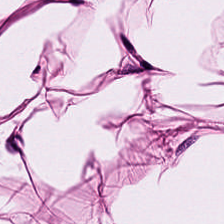

In [62]:
dataset["train"][0]["image"].convert("RGB")

In [63]:
inputs = processor(
    text= processor.apply_chat_template(dataset["train"][0]["messages"]),   # must be a list
    images=dataset["train"][0]["image"].convert("RGB"),
    return_tensors="pt",
    padding=True
)
inputs 

{'input_ids': tensor([[     2,      2,    105,   2364,    109, 255999, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         26214

In [64]:
def collate_fn(examples):

    texts = []
    images = []
    for example in examples:
        images.append([example["image"].convert("RGB")])
        texts.append(processor.apply_chat_template(
            example["messages"], 
            add_generation_prompt = False, 
            tokenize = False
        ).strip())

    
    # Tokenize the texts and process the images
    batch = processor(text = texts, 
        images = images, 
        return_tensors = "pt", 
        padding = True
    )

    # The labels are the input_ids, with the padding and image tokens masked in
    # the loss computation
    labels = batch["input_ids"].clone()

    # Mask image tokens
    image_token_id = [
        processor.tokenizer.convert_tokens_to_ids(
            processor.tokenizer.special_tokens_map["boi_token"]
        )
    ]
    # Mask tokens that are not used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    labels[labels == 262144] = -100

    batch["labels"] = labels
    return batch

##### 3.5 Configure Training Parameters in an SFTConfig

In [65]:
from trl import SFTTrainer, SFTConfig

num_train_epochs = 1 # @param {"type" : "number"}
learning_rate = 2e-4 # @param {"type" : "number"}

args = SFTConfig(
    output_dir = "medgemma-4b-it-sft-lora-crc-5k", 
    num_train_epochs=num_train_epochs,                       # Number of training epochs
    per_device_train_batch_size=4,                           # Batch size per device during training
    per_device_eval_batch_size=4,                            # Batch size per device during evaluation
    gradient_accumulation_steps=4,                           # Number of steps before performing a backward/update pass
    gradient_checkpointing=True,                             # Enable gradient checkpointing to reduce memory usage
    optim="adamw_torch_fused",                               # Use fused AdamW optimizer for better performance
    logging_steps=50,                                        # Number of steps between logs
    save_strategy="epoch",                                   # Save checkpoint every epoch
    eval_strategy="steps",                                   # Evaluate every `eval_steps`
    eval_steps=50,                                           # Number of steps between evaluations
    learning_rate=learning_rate,                             # Learning rate based on QLoRA paper
    bf16=True,                                               # Use bfloat16 precision
    max_grad_norm=0.3,                                       # Max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                                       # Warmup ratio based on QLoRA paper
    lr_scheduler_type="linear",                              # Use linear learning rate scheduler
    push_to_hub=True,                                        # Push model to Hub
    report_to="tensorboard",                                 # Report metrics to tensorboard
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Set gradient checkpointing to non-reentrant to avoid issues
    dataset_kwargs={"skip_prepare_dataset": True},           # Skip default dataset preparation to preprocess manually
    remove_unused_columns = False,                           # Columns are unused for training but needed for data collator
    label_names=["labels"],                                  # Input keys that correspond to the labels
)

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],  
    peft_config=peft,
    processing_class=processor,
    data_collator=collate_fn,
)


/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:1222: UserWarning: Model has `tie_word_embeddings=True` and a tied layer is part of the adapter, but `ensure_weight_tying` is not set to True. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. Check the discussion here: https://github.com/huggingface/peft/issues/2777
  warnings.warn(msg)


In [ ]:
trainer.train() 

In [21]:
trainer.push_to_hub("MedicalImageTexttoText")
processor.push_to_hub("MedicalImageTexttoTextTokenizer")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...-crc-5k/training_args.bin: 100%|##########| 6.29kB / 6.29kB            

  ...40966.a3529990a981.2572.0: 100%|##########| 13.4kB / 13.4kB            

  ...ra-crc-5k/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...ora-crc-5k/tokenizer.json: 100%|##########| 33.4MB / 33.4MB            

  ...adapter_model.safetensors:   1%|1         | 41.9MB / 2.84GB            

No files have been modified since last commit. Skipping to prevent empty commit.


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...pbhfdddmp/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...mpbhfdddmp/tokenizer.json: 100%|##########| 33.4MB / 33.4MB            

CommitInfo(commit_url='https://huggingface.co/SanKav123/MedicalImageTexttoTextTokenizer/commit/0a4f7d70d68bfa761164f9488d1021bb0475037e', commit_message='Upload processor', commit_description='', oid='0a4f7d70d68bfa761164f9488d1021bb0475037e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/SanKav123/MedicalImageTexttoTextTokenizer', endpoint='https://huggingface.co', repo_type='model', repo_id='SanKav123/MedicalImageTexttoTextTokenizer'), pr_revision=None, pr_num=None)

Free up memory before proceeding to evaluate and test the fine-tuned model.

In [22]:
del model
del trainer
torch.cuda.empty_cache()

# 4. Evaluate the fine tuned model

##### 4.1 Prepare test dataset

In [50]:

def format_test_data(example: dict[str, Any]) -> dict[str, Any]:
    example["messages"] = [
        {
            "role": "user", 
            "content": [
                {
                    "type": "image", 
                }, 
                {
                    "type": "text", 
                    "text": PROMPT,
                }
            ]
        }
    ]
    return example


test_data = dataset["test"].shuffle(seed = 42)
test_data = test_data.map(format_test_data)

Map:   0%|          | 0/1436 [00:00<?, ? examples/s]

##### 4.2 Set up for evaluation

In [51]:
import evaluate

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Ground-truth lable
REFERENCES = test_data["label"]

def compute_metrics(predictions: list[int])-> dict[str, float]:
    metrics = {}
    metrics.update(
        accuracy_metric.compute(predictions = predictions, 
                                references = REFERENCES
                            )
    )
    metrics.update(
        f1_metric.compute(predictions = predictions, 
            references = REFERENCES)
    )
    return metrics

##### 4.3 Define a postprocessing function to convert responses to integer class labels before computing metrics,



In [52]:
from datasets import ClassLabel

# Rename the class names to the tissue classes, `X: tissue type`
test_data = test_data.cast_column(
    "label", 
    ClassLabel(names = TISSUE_CLASSES)
)


LABEL_FEATURE = test_data.features["label"]
# Mapping to alternative label format, `(X) tissue type`
ALT_LABELS = dict([
    (label, f"({label.replace(': ', ') ')}") for label in TISSUE_CLASSES
])



def postprocess(prediction: list[dict[str, str]], do_full_match: bool=False) -> int:
    response_text = prediction[0]["generated_text"]
    if do_full_match:
        return LABEL_FEATURE.str2int(response_text)
    for label in TISSUE_CLASSES:
        # Search for `X: tissue type` or `(X) tissue type` in the response
        if label in response_text or ALT_LABELS[label] in response_text:
            return LABEL_FEATURE.str2int(label)
    return -1
     


Casting the dataset:   0%|          | 0/1436 [00:00<?, ? examples/s]

### Compute baseline metrics on the pretrained model

In [39]:
from transformers import pipeline

pt_pipe = pipeline(
    "image-text-to-text",
    model=model_id,
    torch_dtype=torch.bfloat16,
)

# Set `do_sample = False` for deterministic responses
pt_pipe.model.generation_config.do_sample = False
pt_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id
     

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [46]:
print(test_data.features)

{'image': Image(mode=None, decode=True), 'label': ClassLabel(names=['A: adipose', 'B: background', 'C: debris', 'D: lymphocytes', 'E: mucus', 'F: smooth muscle', 'G: normal colon mucosa', 'H: cancer-associated stroma', 'I: colorectal adenocarcinoma epithelium']), 'messages': List({'content': List({'text': Value('string'), 'type': Value('string')}), 'role': Value('string')})}


In [48]:
test_data[0:4]

{'image': [<PIL.Image.Image image mode=RGB size=224x224>,
  <PIL.Image.Image image mode=RGB size=224x224>,
  <PIL.Image.Image image mode=RGB size=224x224>,
  <PIL.Image.Image image mode=RGB size=224x224>],
 'label': [6, 1, 8, 4],
 'messages': [[{'content': [{'text': None, 'type': 'image'},
     {'text': 'What is the most likely tissue type shown in the histopathology image?\nA: adipose\nB: background\nC: debris\nD: lymphocytes\nE: mucus\nF: smooth muscle\nG: normal colon mucosa\nH: cancer-associated stroma\nI: colorectal adenocarcinoma epithelium',
      'type': 'text'}],
    'role': 'user'}],
  [{'content': [{'text': None, 'type': 'image'},
     {'text': 'What is the most likely tissue type shown in the histopathology image?\nA: adipose\nB: background\nC: debris\nD: lymphocytes\nE: mucus\nF: smooth muscle\nG: normal colon mucosa\nH: cancer-associated stroma\nI: colorectal adenocarcinoma epithelium',
      'type': 'text'}],
    'role': 'user'}],
  [{'content': [{'text': None, 'type': '

In [66]:
# Run batch inference on the test dataset
pt_outputs = pt_pipe(
    text=test_data["messages"],
    images=test_data["image"],
    max_new_tokens=40,
    batch_size=64,
    return_full_text=False,
)

pt_predictions = [postprocess(out) for out in pt_outputs]

TypeError: Incorrect format used for image. Should be an url linking to an image, a base64 string, a local path, or a PIL image.

In [ ]:
# Compute metrics
pt_metrics = compute_metrics(pt_predictions)
print(f"Baseline metrics: {pt_metrics}")

#### Compute metrics on the fine-tuned model

Load the base model with the fine-tuned LoRA adapter using the pipeline API.

In [70]:
ft_pipe = pipeline(
    "image-text-to-text",
    model='SanKav123/medgemma-4b-it-sft-lora-crc-5k',
    processor=processor,
    torch_dtype=torch.bfloat16,
)

# Set `do_sample = False` for deterministic responses
ft_pipe.model.generation_config.do_sample = False
ft_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id
# Use left padding during inference
processor.tokenizer.padding_side = "left"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

Device set to use cuda:0


In [72]:
ft_outputs = ft_pipe(
    text=test_data["messages"],
    images=test_data["image"],
    max_new_tokens=20,
    batch_size=64,
    return_full_text=False,
)

ft_predictions = [postprocess(out, do_full_match=True) for out in ft_outputs]

TypeError: Incorrect format used for image. Should be an url linking to an image, a base64 string, a local path, or a PIL image.

In [ ]:
ft_metrics = compute_metrics(ft_predictions)
print(f"Fine-tuned metrics: {ft_metrics}")